In [1]:
import pandas as pd

In [3]:
import zipfile
import os

# Specify the path of the zip file
zip_file_path = '/content/webanno.zip'

# Specify the destination directory where the folder will be extracted
extract_dir = '/content/'

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# Optionally, remove the zip file after extraction
os.remove(zip_file_path)

In [4]:
import zipfile
import os

# Specify the path of the zip file
zip_file_path = '/content/source.zip'

# Specify the destination directory where the folder will be extracted
extract_dir = '/content/'

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# Optionally, remove the zip file after extraction
os.remove(zip_file_path)

In [28]:
import os
import pandas as pd
import csv

# Initialize lists to store source text and annotation dataframes
source_dfs = []
annotation_dfs = []

# Walk through the source directory and read TXT files
source_dir = '/content/source'
annotation_dir = '/content/webanno'

for root, dirs, files in os.walk(source_dir):
    for file in files:
        if file.endswith('.txt'):
            try:
                with open(os.path.join(root, file), 'r', encoding='utf-8', errors='ignore') as f:
                    source_text = f.read()

                # Create a dataframe for the source text
                df_source = pd.DataFrame([source_text], columns=['Source_Text'])
                # Add a column with the name of the txt file
                df_source['File_Name'] = file

                # Append the dataframe to the list
                source_dfs.append(df_source)

                # Build the corresponding annotation directory path and TSV filename
                annotation_folder = file  # Use the complete file name, including '.txt', as folder name
                tsv_file = 'annotation.tsv'

                # Build the full path to the TSV file
                tsv_path = os.path.join(annotation_dir, annotation_folder, tsv_file)

                if os.path.exists(tsv_path):
                    # Read the TSV into a dataframe
                    df_annotation = pd.read_csv(tsv_path, sep='\t', comment='#', header=None, 
                                                names=['Token_ID', 'Character_Offset', 'Token', 'Annotation_1', 'Annotation_2', 'Annotation_3', 'Annotation_4'], 
                                                encoding='utf-8', na_filter=False, keep_default_na=False, on_bad_lines='skip',
                                                quoting=csv.QUOTE_NONE)  # Add this line
                    # Add a column with the name of the txt file
                    df_annotation['File_Name'] = file

                    # Append the dataframe to the list
                    annotation_dfs.append(df_annotation)

            except Exception as e:
                print(f"An error occurred with file {file}. Error: {str(e)}")

# Concatenate all dataframes
df_all_source = pd.concat(source_dfs, ignore_index=True)
df_all_annotation = pd.concat(annotation_dfs, ignore_index=True)

# Print the combined dataframes to check
print(df_all_source)
print(df_all_annotation)

                                          Source_Text  \
0   At the time of my examination, it had become f...   
1   Grooms and Hostlers daily inhale a large quant...   
2   OVERDO in the stocks. People, etc.\n\nEnter QU...   
3   At the foote of the Mountaine there is a hole,...   
4   For as the Heathen Epictetus tels vs, wee try ...   
..                                                ...   
80  Selection of passages from 18th century plays ...   
81  What Madness therefore is it, to offer Sacrifi...   
82  \nThis erroneous opinion appears to have been ...   
83  \nSection1 .\n\n\nIn the first place, I am of ...   
84  By taking their experience as a rule for our o...   

                                            File_Name  
0   006E W Murdoch 1858 Report of the Medical Offi...  
1   041E Charles Turner Thackrah 1831 The effects ...  
2   022E Ben Jonson 1614 Bartholomew Fair__33_THE.txt  
3   044E Fynes Moryson 1617 An Itinerary__58_distr...  
4   072E Richard Middleton 1619 Goo

In [29]:
# Fill missing values in each row with an empty string
df_all_annotation['Annotation_1'] = df_all_annotation['Annotation_1'].fillna('')
df_all_annotation['Annotation_2'] = df_all_annotation['Annotation_2'].fillna('')
df_all_annotation['Annotation_3'] = df_all_annotation['Annotation_3'].fillna('')
df_all_annotation['Annotation_4'] = df_all_annotation['Annotation_4'].fillna('')

# Merge the columns into a single 'Annotation' column
df_all_annotation['Annotation'] = df_all_annotation['Annotation_1'] + ' ' + df_all_annotation['Annotation_2'] + ' ' + df_all_annotation['Annotation_3'] + ' ' + df_all_annotation['Annotation_4']

# Drop the individual 'Annotation_1' to 'Annotation_4' columns
df_all_annotation = df_all_annotation.drop(columns=['Annotation_1', 'Annotation_2', 'Annotation_3', 'Annotation_4'])

# remove unwanted characters
df_all_annotation['Annotation'] = df_all_annotation['Annotation'].str.replace(r'\[\d+\]', '')  # remove [numbers]
df_all_annotation['Annotation'] = df_all_annotation['Annotation'].str.replace(r'_', '')  # remove underscores
df_all_annotation['Annotation'] = df_all_annotation['Annotation'].str.replace(r'\\', '')  # remove backslashes


<ipython-input-29-a50cda2c6661>:14: FutureWarning: The default value of regex will change from True to False in a future version.
  df_all_annotation['Annotation'] = df_all_annotation['Annotation'].str.replace(r'\[\d+\]', '')  # remove [numbers]
<ipython-input-29-a50cda2c6661>:16: FutureWarning: The default value of regex will change from True to False in a future version.
  df_all_annotation['Annotation'] = df_all_annotation['Annotation'].str.replace(r'\\', '')  # remove backslashes


In [30]:
df_all_annotation['Annotation'].value_counts()

                                             117898
SmellSource                                    2835
Circumstances                                  1564
Effect                                         1392
Quality                                        1187
                                              ...  
SmellWord *|*|* 52-11|52-3[370]|52-1              1
SmellWord *|*|* 49-104|49-95[360]|49-110          1
SmellWord *|* 49-47[340]|49-55[350]               1
SmellWord *|* 49-1[330]|49-14                     1
SmellWord * 39-77[690]                            1
Name: Annotation, Length: 1601, dtype: int64

In [31]:
import re
from collections import defaultdict

def clean_annotation(annotation):
    # Initialize a dictionary to count occurrences of each label
    label_counts = defaultdict(int)

    # Use a regular expression to find all occurrences of labels with alphabetic characters.
    matches = re.findall(r'\b[A-Za-z_\-]+\b', annotation)

    # If there are no matches, return an empty string
    if not matches:
        return ''

    # If label is followed by 'Anaphoric', merge them and treat them as a single label
    merged_matches = []
    for i in range(len(matches)-1):
        if matches[i+1] == 'Anaphoric':
            merged_matches.append(matches[i] + 'Anaphoric')
        elif matches[i] != 'Anaphoric':  # Prevent adding 'Anaphoric' standalone
            merged_matches.append(matches[i])

    # Handle the last match separately to avoid index error
    if matches[-1] != 'Anaphoric':
        merged_matches.append(matches[-1])

    # Count occurrences of each label
    for match in merged_matches:
        label_counts[match] += 1

    # Include each label only once in the cleaned annotation
    cleaned_annotation = '|'.join(label_counts.keys())

    return cleaned_annotation

# Apply the function to the Annotation column
df_all_annotation['Annotation'] = df_all_annotation['Annotation'].apply(clean_annotation)

In [32]:
# Import regular expressions library
import re

def clean_annotation(annotation):
    # Use a regular expression to find all words in the string.
    # '\b\w+\b' matches word boundaries around one or more word characters.
    words = re.findall(r'\b\w+\b', annotation)
    
    # Join the words with the pipe character and return the result.
    return '|'.join(words)

# Apply the function to the Annotation column
df_all_annotation['Annotation'] = df_all_annotation['Annotation'].apply(clean_annotation)

In [33]:
df_all_annotation.Annotation.unique()

array(['', 'SmellWord', 'Quality', 'Effect', 'Perceiver', 'Time',
       'SmellSource', 'Quality|SmellWord', 'OdourCarrier', 'Location',
       'Circumstances', 'SmellWordAnaphoric', 'OdourCarrierAnaphoric',
       'SmellWord|Quality', 'Perceiver|OdourCarrierAnaphoric',
       'SmellSourceAnaphoric', 'EvokedOdorant',
       'Circumstances|SmellSource', 'Effect|Perceiver',
       'PerceiverAnaphoric', 'SmellSource|SmellWord',
       'SmellSource|SmellSourceAnaphoric', 'Effect|Samespan',
       'Effect|Quality', 'Effect|SmellWord', 'LocationAnaphoric',
       'Quality|SmellSource', 'SmellWord|SmellSource',
       'Effect|SmellSource', 'EvokedOdorantAnaphoric',
       'Circumstances|OdourCarrier', 'SmellWord|OdourCarrier',
       'Circumstances|PerceiverAnaphoric',
       'SmellSourceAnaphoric|AnaphoricAnaphoric', 'Circumstances|Time',
       'Effect|Location', 'EffectAnaphoric', 'SmellSource|Quality',
       'OdourCarrier|SmellWord', 'Location|SmellWord', 'Location|Quality',
       'Smel

In [34]:
def clean_annotation(annotation):
    if '|' in annotation:
        return ''
    else:
        return annotation

df_all_annotation['Annotation'] = df_all_annotation['Annotation'].apply(clean_annotation)

In [35]:
df_all_annotation

,Token_ID,Character_Offset,Token,File_Name,Annotation
0,1-1,0-2,At,006E W Murdoch 1858 Report of the Medical Offi...,
1,1-2,3-6,the,006E W Murdoch 1858 Report of the Medical Offi...,
2,1-3,7-11,time,006E W Murdoch 1858 Report of the Medical Offi...,
3,1-4,12-14,of,006E W Murdoch 1858 Report of the Medical Offi...,
4,1-5,15-17,my,006E W Murdoch 1858 Report of the Medical Offi...,
...,...,...,...,...,...
129650,39-75,17158-17163,smell,028E 1828 Considerations on the nuisance of co...,SmellWord
129651,39-76,17164-17170,enters,028E 1828 Considerations on the nuisance of co...,
129652,39-77,17171-17174,his,028E 1828 Considerations on the nuisance of co...,Location
129653,39-78,17175-17180,house,028E 1828 Considerations on the nuisance of co...,Location


In [36]:
#df_all_annotation['Annotation'] = df_all_annotation['Annotation'].apply(lambda x: x if x in ['SmellWord', 'SmellSource', 'Quality'] else '')

In [37]:
#df_all_annotation.Annotation.unique()

array(['', 'SmellWord', 'Quality', 'SmellSource'], dtype=object)

In [43]:
# df_all_annotation['Sentence_ID'] = df_all_annotation['Token_ID'].apply(lambda x: x.split('-')[0])

# # Group tokens by sentences and create a list of annotations for each sentence
# sentence_annotations = df_all_annotation.groupby('Sentence_ID')['Annotation'].apply(list)

# # Filter out sentences that do not contain any of the three labels
# valid_sentence_ids = sentence_annotations[sentence_annotations.apply(lambda annotations: any(label in annotations for label in ['SmellWord', 'SmellSource', 'Quality']))].index

# # Filter df_all_annotation to only include tokens from valid sentences
# df_all_annotation = df_all_annotation[df_all_annotation['Sentence_ID'].isin(valid_sentence_ids)]


In [44]:
# df_all_annotation

,Token_ID,Character_Offset,Token,File_Name,Annotation,Sentence_ID
0,1-1,0-2,At,006E W Murdoch 1858 Report of the Medical Offi...,,1
1,1-2,3-6,the,006E W Murdoch 1858 Report of the Medical Offi...,,1
2,1-3,7-11,time,006E W Murdoch 1858 Report of the Medical Offi...,,1
3,1-4,12-14,of,006E W Murdoch 1858 Report of the Medical Offi...,,1
4,1-5,15-17,my,006E W Murdoch 1858 Report of the Medical Offi...,,1
...,...,...,...,...,...,...
129650,39-75,17158-17163,smell,028E 1828 Considerations on the nuisance of co...,SmellWord,39
129651,39-76,17164-17170,enters,028E 1828 Considerations on the nuisance of co...,,39
129652,39-77,17171-17174,his,028E 1828 Considerations on the nuisance of co...,,39
129653,39-78,17175-17180,house,028E 1828 Considerations on the nuisance of co...,,39


In [47]:
# # Find the length of the longest token
# length_longest_token = df_all_annotation['Token'].apply(len).max()

# print(length_longest_token)

23


In [39]:
# from google.colab import drive
# drive.mount('/content/drive')

# # Save the dataframe to a csv file
# df_all_annotation.to_csv('df_all_annotation.csv', index=False)

# # Assuming that df_all_annotation is your DataFrame
# df_all_annotation.to_csv('/content/drive/My Drive/df_all_annotation.csv', index=False)

Mounted at /content/drive


In [14]:
import pandas as pd
import numpy as np

# Assume df_all_annotation is your dataframe with 'Token' and 'Annotation' columns
df_all_annotation['Token_str'] = df_all_annotation['Token'].astype(str)

# Determine if the token is the end of a sentence based on its last character
df_all_annotation['sentence_end'] = df_all_annotation['Token_str'].apply(lambda x: True if x.endswith(('.', '!', '?')) else False)

# Determine if the token is the start of a sentence
df_all_annotation['sentence_start'] = df_all_annotation['sentence_end'].shift(fill_value=False)
df_all_annotation['sentence_start'] = df_all_annotation['sentence_start'].apply(lambda x: not x)

# Here we fix the issue with sentence_id assignment
# Add sentence_id to each sentence, incrementing when the token is the end of a sentence
df_all_annotation['sentence_id'] = df_all_annotation['sentence_end'].cumsum()

# Detokenize the tokens by sentence
df_all_annotation['detokenized'] = df_all_annotation.groupby('sentence_id')['Token_str'].transform(lambda x: ' '.join(x))

# Generate binary label column, if any token in a sentence has a label then it's set to 1 else 0
df_all_annotation['binary_values'] = df_all_annotation.groupby('sentence_id')['Annotation'].transform(lambda x: 1 if any(x != '') else 0)

# If you want to remove duplicate rows (as detokenization and binary label generation is done on sentence level)
df_all_annotation = df_all_annotation.drop_duplicates(subset='sentence_id')

<ipython-input-15-8b99abd4b3fb>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all_annotation['sentence_length'] = df_all_annotation['detokenized'].apply(lambda x: len(x.split()))


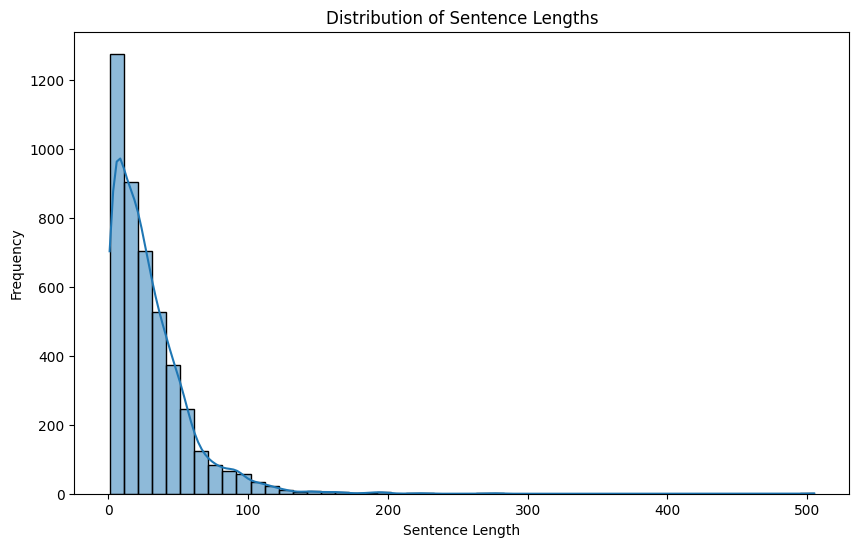

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the length of each sentence
df_all_annotation['sentence_length'] = df_all_annotation['detokenized'].apply(lambda x: len(x.split()))

# Visualize the lengths of sentences using a histogram
plt.figure(figsize=(10,6))
sns.histplot(df_all_annotation['sentence_length'], bins=50, kde=True)
plt.title('Distribution of Sentence Lengths')
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')
plt.show()

In [16]:
df_all_annotation

,Token_ID,Character_Offset,Token,File_Name,Annotation,Token_str,sentence_end,sentence_start,sentence_id,detokenized,binary_values,sentence_length
0,1-1,0-2,At,006E W Murdoch 1858 Report of the Medical Offi...,,At,False,True,0,"At the time of my examination , it had become ...",0,43
43,1-44,226-227,.,006E W Murdoch 1858 Report of the Medical Offi...,,.,True,True,1,". The stench was so great , that several of th...",1,23
66,2-23,336-337,.,006E W Murdoch 1858 Report of the Medical Offi...,,.,True,True,2,". The cesspool has been since emptied , and th...",0,25
91,3-25,467-468,.,006E W Murdoch 1858 Report of the Medical Offi...,,.,True,True,3,. Sickness and Mortality,0,4
95,4-4,491-492,.,006E W Murdoch 1858 Report of the Medical Offi...,,.,True,True,4,. Forty-four deaths were registered during the...,0,10
...,...,...,...,...,...,...,...,...,...,...,...,...
129443,37-1,16189-16190,.,028E 1828 Considerations on the nuisance of co...,,.,True,True,4451,". "" Mr SAMUEL COOPER , lives in Lower Edmund S...",0,42
129485,38-42,16377-16378,.,028E 1828 Considerations on the nuisance of co...,,.,True,True,4452,. 5 less for a house than he did three years a...,0,49
129534,38-91,16590-16591,.,028E 1828 Considerations on the nuisance of co...,,.,True,True,4453,. 50 or L,0,4
129538,38-95,16600-16601,.,028E 1828 Considerations on the nuisance of co...,,.,True,True,4454,. 60 as before they were established ; that th...,0,37


In [ ]:
import pandas as pd

# Assume df_all_annotation is your dataframe with 'Token' and 'Annotation' columns
df_all_annotation['Token_str'] = df_all_annotation['Token'].astype(str)

# Determine if the token is the end of a sentence based on its last character
df_all_annotation['sentence_end'] = df_all_annotation['Token_str'].apply(lambda x: True if x.endswith(('.', '!', '?')) else False)

# Determine if the token is the start of a sentence
df_all_annotation['sentence_start'] = df_all_annotation['sentence_end'].shift(fill_value=False)
df_all_annotation['sentence_start'] = df_all_annotation['sentence_start'].apply(lambda x: not x)

# Add sentence_id to each sentence, incrementing only for tokens that are the start of a sentence
df_all_annotation['sentence_id'] = (df_all_annotation['sentence_start'] & df_all_annotation['sentence_end']).cumsum()

# Detokenize the tokens by sentence, excluding sentence end tokens that are at the start of a sentence
df_all_annotation['detokenized'] = df_all_annotation[df_all_annotation['sentence_start']].groupby('sentence_id')['Token_str'].transform(lambda x: ' '.join(x))

# Generate binary label column, if any token in a sentence has a label then it's set to 1 else 0
df_all_annotation['binary_values'] = df_all_annotation.groupby('sentence_id')['Annotation'].transform(lambda x: 1 if any(x != '') else 0)

# If you want to remove duplicate rows (as detokenization and binary label generation is done on sentence level)
df_all_annotation = df_all_annotation.drop_duplicates(subset='sentence_id')

df_all_annotation

,Token_ID,Character_Offset,Token,File_Name,Annotation,Token_str,sentence_end,sentence_start,sentence_id,detokenized,binary_values
0,1-1,0-3,The,040E City of London 1921 board of health repor...,,The,False,True,0,The condition of food used and stored upon the...,0
32,1-33,189-190,.,040E City of London 1921 board of health repor...,,.,True,True,1,. difficulty of a subsidiary character is the ...,1
55,2-23,339-340,.,040E City of London 1921 board of health repor...,,.,True,True,2,. the nuisance is caused by the burning of ref...,1
110,3-55,622-623,.,040E City of London 1921 board of health repor...,,.,True,True,3,. previous reports attention has been directed...,0
148,4-38,844-845,.,040E City of London 1921 board of health repor...,,.,True,True,4,. is not necessary either that such places sho...,0
...,...,...,...,...,...,...,...,...,...,...,...
129499,4-42,860-861,.,042E Hoffman and Ramazzini 1744 Endemical dise...,,.,True,True,4428,. therefore I do not wonder that the animal Sp...,1
129544,5-45,1112-1113,.,042E Hoffman and Ramazzini 1744 Endemical dise...,,.,True,True,4429,". I have oftentimes seen Women of a tender , n...",1
129574,6-30,1271-1272,.,042E Hoffman and Ramazzini 1744 Endemical dise...,,.,True,True,4430,. be further satisfied of the pernicious Smell...,1
129615,7-41,1514-1515,.,042E Hoffman and Ramazzini 1744 Endemical dise...,,.,True,True,4431,". adds , that Ox-tallow gives a more noisome S...",1


<ipython-input-47-8b99abd4b3fb>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all_annotation['sentence_length'] = df_all_annotation['detokenized'].apply(lambda x: len(x.split()))


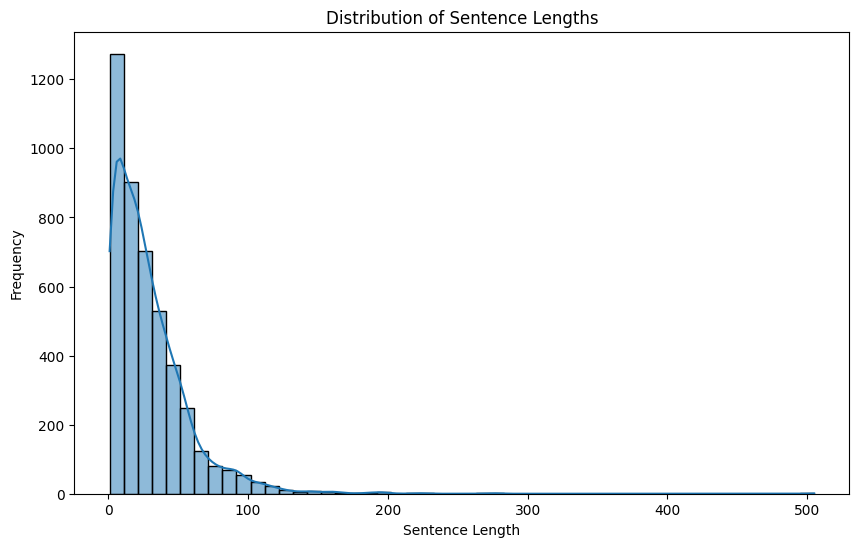

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the length of each sentence
df_all_annotation['sentence_length'] = df_all_annotation['detokenized'].apply(lambda x: len(x.split()))

# Visualize the lengths of sentences using a histogram
plt.figure(figsize=(10,6))
sns.histplot(df_all_annotation['sentence_length'], bins=50, kde=True)
plt.title('Distribution of Sentence Lengths')
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')
plt.show()

In [ ]:
df_with_binary_1 = df_all_annotation[df_all_annotation['binary_values'] == 1]
df_with_binary_1

,Token_ID,Character_Offset,Token,File_Name,Annotation,Token_str,sentence_end,sentence_start,sentence_id,detokenized,binary_values,sentence_length
32,1-33,189-190,.,040E City of London 1921 board of health repor...,,.,True,True,1,. A difficulty of a subsidiary character is th...,1,23
55,2-23,339-340,.,040E City of London 1921 board of health repor...,,.,True,True,2,. When the nuisance is caused by the burning o...,1,55
288,9-11,1677-1678,.,040E City of London 1921 board of health repor...,,.,True,True,10,. It will be readily seen that night-time is t...,1,49
380,2-43,450-451,.,067E Richardson 1910 War Police and Watch Dogs...,,.,True,True,12,. Strongly scented ground makes tracking diffi...,1,34
414,3-34,638-639,.,067E Richardson 1910 War Police and Watch Dogs...,,.,True,True,13,. Newly ploughed fields are unprofitable track...,1,35
...,...,...,...,...,...,...,...,...,...,...,...,...
129457,3-2,646-647,.,042E Hoffman and Ramazzini 1744 Endemical dise...,,.,True,True,4450,. So on the other hand Things of an unsavoury ...,1,42
129499,4-42,860-861,.,042E Hoffman and Ramazzini 1744 Endemical dise...,,.,True,True,4451,. And therefore I do not wonder that the anima...,1,45
129544,5-45,1112-1113,.,042E Hoffman and Ramazzini 1744 Endemical dise...,,.,True,True,4452,. Nay I have oftentimes seen Women of a tender...,1,30
129574,6-30,1271-1272,.,042E Hoffman and Ramazzini 1744 Endemical dise...,,.,True,True,4453,. To be further satisfied of the pernicious Sm...,1,41


In [ ]:
df_with_binary_1.detokenized[32]

'. A difficulty of a subsidiary character is the objection which neighbouring tenants frequently make to the smells of cooking which occasionally arise'

In [ ]:
df_with_binary_0 = df_all_annotation[df_all_annotation['binary_values'] == 0]

In [ ]:
# Sample 40% of the dataframe where binary_values are 0
df_sampled_0 = df_with_binary_0.sample(frac=0.4)

# Concatenate df_with_binary_1 with the sampled dataframe
df_combined = pd.concat([df_with_binary_1, df_sampled_0], ignore_index=True)

In [ ]:
df_combined

,Token_ID,Character_Offset,Token,File_Name,Annotation,Token_str,sentence_end,sentence_start,sentence_id,detokenized,binary_values,sentence_length
0,1-33,189-190,.,040E City of London 1921 board of health repor...,,.,True,True,1,. A difficulty of a subsidiary character is th...,1,23
1,2-23,339-340,.,040E City of London 1921 board of health repor...,,.,True,True,2,. When the nuisance is caused by the burning o...,1,55
2,9-11,1677-1678,.,040E City of London 1921 board of health repor...,,.,True,True,10,. It will be readily seen that night-time is t...,1,49
3,2-43,450-451,.,067E Richardson 1910 War Police and Watch Dogs...,,.,True,True,12,. Strongly scented ground makes tracking diffi...,1,34
4,3-34,638-639,.,067E Richardson 1910 War Police and Watch Dogs...,,.,True,True,13,. Newly ploughed fields are unprofitable track...,1,35
...,...,...,...,...,...,...,...,...,...,...,...,...
2442,15-34,1826-1827,.,080E Duncan Mcdonald 1800 New town cook__214_d...,,.,True,True,3001,". With us , the smallest kinds , particularly ...",0,27
2443,19-10,5015-5016,?,077E Richard Braithwaite 1620 Essays upon the ...,,?,True,True,801,"? or how wish any thing , hauing whatsoeuer I ...",0,11
2444,1-17,68-69,.,072E Richard Middleton 1619 Goodnes the blesse...,,.,True,True,4079,. What figure or stampe hath this coine,0,8
2445,1-22,119-120,.,018E Thomas Laycock 1865 Notes on Fetid Bronch...,,.,True,True,3896,. This was probably a lobar broncho-pneumonia ...,0,38


In [ ]:
train_df = df_combined[['detokenized', 'binary_values']]

In [ ]:
train_df

,detokenized,binary_values
0,. A difficulty of a subsidiary character is th...,1
1,. When the nuisance is caused by the burning o...,1
2,. It will be readily seen that night-time is t...,1
3,. Strongly scented ground makes tracking diffi...,1
4,. Newly ploughed fields are unprofitable track...,1
...,...,...
2442,". With us , the smallest kinds , particularly ...",0
2443,"? or how wish any thing , hauing whatsoeuer I ...",0
2444,. What figure or stampe hath this coine,0
2445,. This was probably a lobar broncho-pneumonia ...,0


In [ ]:
import string

# Define a translation table that maps every punctuation character to None
translator = str.maketrans('', '', string.punctuation)

# Use the translation table to remove punctuation from each cell
train_df['detokenized'] = train_df['detokenized'].str.translate(translator)

# Convert the text to lowercase
train_df['detokenized'] = train_df['detokenized'].str.lower()

<ipython-input-100-2c1454e8ff3c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['detokenized'] = train_df['detokenized'].str.translate(translator)
<ipython-input-100-2c1454e8ff3c>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['detokenized'] = train_df['detokenized'].str.lower()


<ipython-input-101-0bfea4eb74b7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['sentence_length'] = train_df['detokenized'].apply(lambda x: len(x.split()))


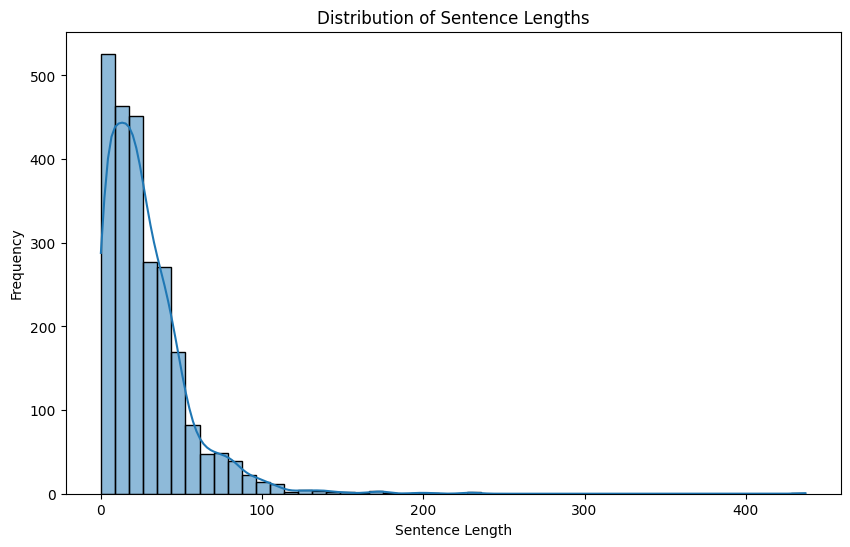

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the length of each sentence
train_df['sentence_length'] = train_df['detokenized'].apply(lambda x: len(x.split()))

# Visualize the lengths of sentences using a histogram
plt.figure(figsize=(10,6))
sns.histplot(train_df['sentence_length'], bins=50, kde=True)
plt.title('Distribution of Sentence Lengths')
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Calculate the length of each sentence
train_df['sentence_length'] = train_df['detokenized'].apply(lambda x: len(x.split()))

# Get the maximum sentence length
max_sentence_length = train_df['sentence_length'].max()

print(f"The maximum sentence length is: {max_sentence_length}")

The maximum sentence length is: 437


<ipython-input-103-1c49806d4f08>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['sentence_length'] = train_df['detokenized'].apply(lambda x: len(x.split()))


In [ ]:
train_df

,detokenized,binary_values,sentence_length
0,a difficulty of a subsidiary character is the...,1,22
1,when the nuisance is caused by the burning of...,1,51
2,it will be readily seen that nighttime is the...,1,43
3,strongly scented ground makes tracking diffic...,1,28
4,newly ploughed fields are unprofitable tracki...,1,29
...,...,...,...
2442,with us the smallest kinds particularly tho...,0,22
2443,or how wish any thing hauing whatsoeuer i de...,0,9
2444,what figure or stampe hath this coine,0,7
2445,this was probably a lobar bronchopneumonia in...,0,34


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
train_df.to_csv('/content/drive/MyDrive/train_df.csv', index=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Assume df is your DataFrame and 'text_column' is the column containing sentences
train_df = train_df.dropna(subset=['detokenized'])

In [ ]:
train_df

,detokenized,binary_values,sentence_length
0,a difficulty of a subsidiary character is the...,1,22
1,when the nuisance is caused by the burning of...,1,51
2,it will be readily seen that nighttime is the...,1,43
3,strongly scented ground makes tracking diffic...,1,28
4,newly ploughed fields are unprofitable tracki...,1,29
...,...,...,...
2442,with us the smallest kinds particularly tho...,0,22
2443,or how wish any thing hauing whatsoeuer i de...,0,9
2444,what figure or stampe hath this coine,0,7
2445,this was probably a lobar bronchopneumonia in...,0,34
